In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
from utils.dataset_processing import evaluation, grasp
from utils.dataset_processing.grasp import GraspRectangles, detect_grasps
from utils.data.cornell_sal import CornellSalDataset
from skimage.filters import gaussian
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

device = torch.device("cuda:0")

In [2]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def post_process_output(q_img, cos_img, sin_img, width_img):
    """
    Post-process the raw output of the GG-CNN, convert to numpy arrays, apply filtering.
    :param q_img: Q output of GG-CNN (as torch Tensors)
    :param cos_img: cos output of GG-CNN
    :param sin_img: sin output of GG-CNN
    :param width_img: Width output of GG-CNN
    :return: Filtered Q output, Filtered Angle output, Filtered Width output
    """
    q_img = q_img.detach().cpu().numpy().squeeze()
    ang_img = (torch.atan2(sin_img, cos_img) / 2.0).detach().cpu().numpy().squeeze()
    width_img = width_img.detach().cpu().numpy().squeeze() * 150.0

    q_img = gaussian(q_img, 2.0, preserve_range=True)
    ang_img = gaussian(ang_img, 2.0, preserve_range=True)
    width_img = gaussian(width_img, 1.0, preserve_range=True)

    return q_img, ang_img, width_img

In [3]:
def activation_map(X, target, y, model, loss='grasp'):
    model.eval()
    X.requires_grad_()
    
    lossd = model.compute_loss(X, target, y)
    
    grasploss = lossd['loss']['grasp']
    classloss = lossd['loss']['class']
    
    if loss == 'grasp':
        grasploss.backward()
    elif loss == 'class':
        classloss.backward()
    elif loss == 'combined':
        grasploss.backward(retain_graph=True)
        classloss.backward()
    else:
        print('No Loss implemented')
    
    activation = torch.abs(X.grad)
    activation, _ = torch.max(activation, 1)
    activation = activation.data
    
    return activation
    
def show_activation_maps(X, target, y, model, activation='grasp'):
    pos, cos, sin, width, pred = model(X)
    
    q_img, ang_img, width_img = post_process_output(pos, cos, sin, width)
    
    saliency = activation_map(X, target, y, model, loss=activation)
    activation = saliency.cpu().squeeze().numpy()
    
    N = X.shape[0]
    
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].detach().cpu().numpy().transpose(1,2,0))
        plt.axis('off')
        plt.subplot(2, N, N + i + 1)
        plt.imshow(activation, cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()
    
def plot_output(img, grasp_q_img, grasp_angle_img, no_grasps=1, grasp_width_img=None):
    """
    Plot the output of a GG-CNN
    :param rgb_img: RGB Image
    :param grasp_q_img: Q output of GG-CNN
    :param grasp_angle_img: Angle output of GG-CNN
    :param no_grasps: Maximum number of grasps to plot
    :param grasp_width_img: (optional) Width output of GG-CNN
    :return:
    """
    gs = detect_grasps(grasp_q_img, grasp_angle_img, width_img=grasp_width_img, no_grasps=no_grasps)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(img)
    for g in gs:
        g.plot(ax)
    ax.axis('off')

    ax = fig.add_subplot(2, 2, 3)
    plot = ax.imshow(grasp_q_img, cmap='jet', vmin=0, vmax=1)
    ax.set_title('Q')
    ax.axis('off')
    plt.colorbar(plot)

    ax = fig.add_subplot(2, 2, 4)
    plot = ax.imshow(grasp_angle_img, cmap='hsv', vmin=-np.pi / 2, vmax=np.pi / 2)
    ax.set_title('Angle')
    ax.axis('off')
    plt.colorbar(plot)

    plt.show()

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
topil = transforms.ToPILImage()

data = CornellSalDataset('/media/will/research/cornell/images', 'annotations/coco.json', include_depth=True, include_rgb=True, train=False, random_rotate=True, random_zoom=True, transform=transform)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [5]:
dataload = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
images = []
classes = []
grasps = []
for i in dataload:
    images.append(i[0].to(device))
    classes.append(i[1].to(device))
    grasps.append(tuple(x.to(device) for x in i[2]))

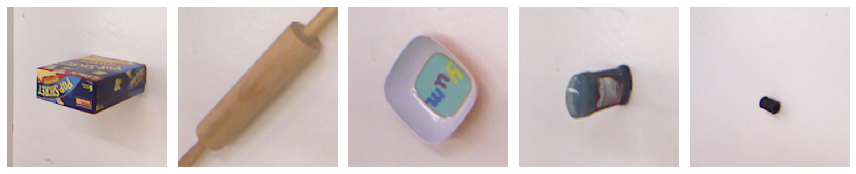

In [6]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i].squeeze(0).cpu().numpy()[1:,:,:].transpose(1,2,0))
    plt.axis('off')
plt.gcf().tight_layout()

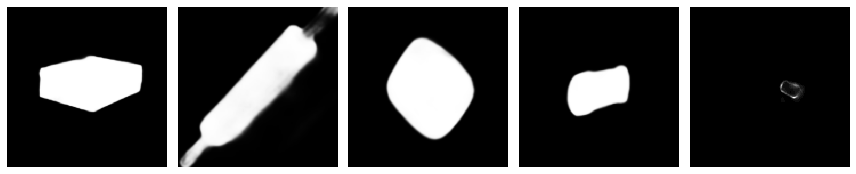

In [7]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(classes[i].squeeze().cpu().numpy())
    plt.axis('off')
plt.gcf().tight_layout()

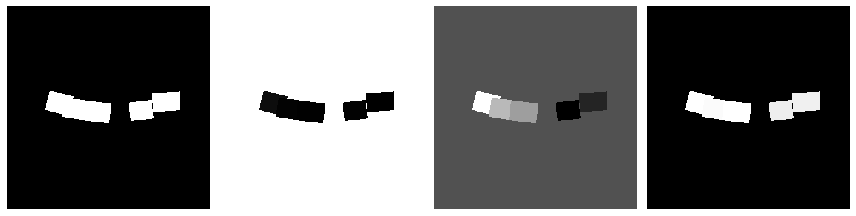

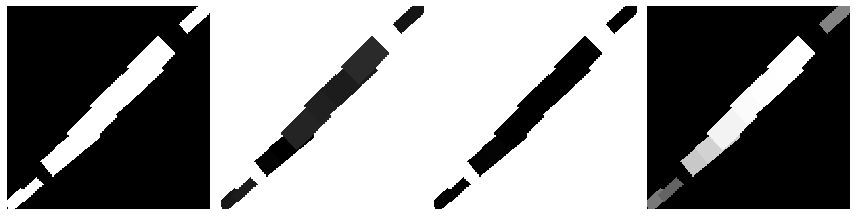

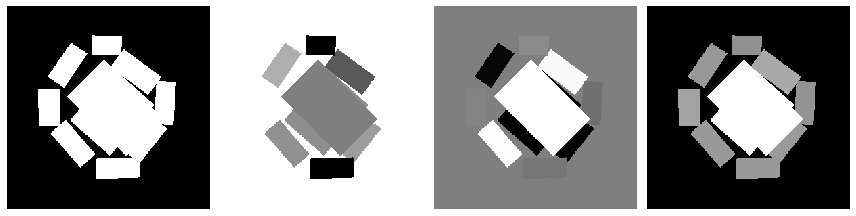

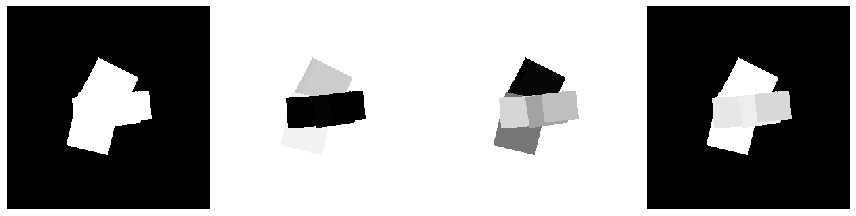

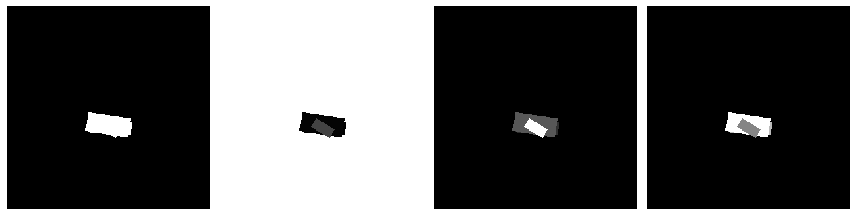

In [8]:
for j in range(5):
    plt.figure(figsize=(12,6))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(grasps[j][i].squeeze().cpu().numpy())
        plt.axis('off')
    plt.gcf().tight_layout()

In [9]:
def output(i, net, title=None):
    for param in net.parameters():
        param.requires_grad = False
    
    fig1, f1_axes = plt.subplots(ncols=2, nrows=4, constrained_layout=True)

    if title is not None:
        fig1.suptitle(title)
        
    q_out, cos_out, sin_out, width_out, sal_out = net(images[i])
    
    if images[i].shape[1] == 4:
        image = images[i].detach().cpu().squeeze(0).numpy()[1:,:,:].transpose((1,2,0))
    else: 
        image = images[i].detach().cpu().squeeze(0).numpy().transpose((1,2,0)) 
    
    f1_axes[0][0].imshow(image)
    f1_axes[0][0].set_title('input')
    f1_axes[0][0].axis('off')
    f1_axes[0][1].imshow(classes[i].detach().cpu().squeeze().numpy())
    f1_axes[0][1].set_title('saliency ground truth')
    f1_axes[0][1].axis('off')
    q_out, ang_out, w_out = post_process_output(q_out.detach(),
                                            cos_out.detach(),
                                            sin_out.detach(),
                                            width_out.detach())

    gs = grasp.detect_grasps(q_out, ang_out, width_img=w_out)
    for g in gs:
        g.plot(f1_axes[1][0])
    f1_axes[1][0].imshow(image)
    f1_axes[1][0].set_title('grasp')
    f1_axes[1][0].axis('off')

    saliency = topil(sal_out.detach().squeeze().cpu())
    f1_axes[1][1].imshow(saliency)
    f1_axes[1][1].set_title('saliency output')
    f1_axes[1][1].axis('off')

    gactivation = activation_map(images[i], classes[i], grasps[i], net, loss='grasp')
    cactivation = activation_map(images[i], classes[i], grasps[i], net, loss='class')
    activation = activation_map(images[i], classes[i], grasps[i], net, loss='combined')

    f1_axes[2][0].imshow(gactivation.detach().squeeze().cpu(), cmap='hot')
    f1_axes[2][0].set_title('grasp activation')
    f1_axes[2][0].axis('off')

    f1_axes[2][1].imshow(cactivation.detach().squeeze().cpu(), cmap='hot')
    f1_axes[2][1].set_title('class activation')
    f1_axes[2][1].axis('off')

    f1_axes[3][0].imshow(q_out, cmap='jet', vmin=0, vmax=1)
    f1_axes[3][0].set_title('Q')
    f1_axes[3][0].axis('off')

    f1_axes[3][1].imshow(ang_out, cmap='hsv', vmin=-np.pi / 2, vmax=np.pi / 2)
    f1_axes[3][1].set_title('Angle')
    f1_axes[3][1].axis('off')
        
    plt.show()

In [10]:
i = 1

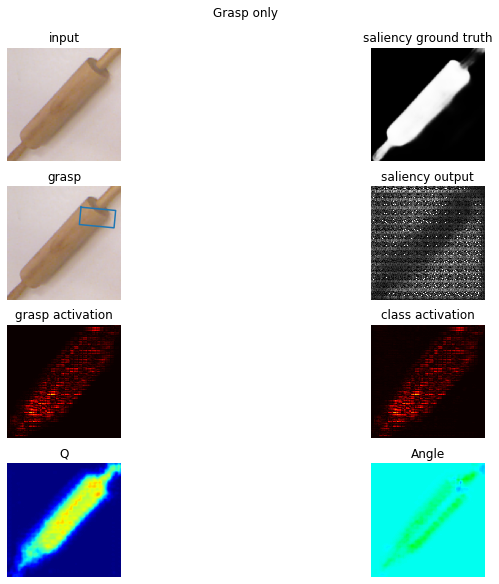

In [11]:
net = torch.load('/media/will/research/mtgrasp/output/models/Saliency_mt/200505_2039_grasponlynosaliencyrgbd/epoch_29_iou_0.82_maxf_0.04')
net.to(device)
net.eval()

output(i, net, title='Grasp only')

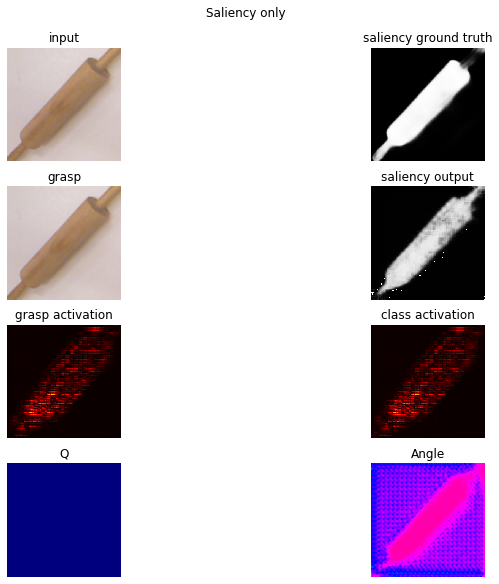

In [12]:
net = torch.load('/media/will/research/mtgrasp/output/models/Saliency_mt/200506_1556_rgbdsaliency/epoch_27_iou_0.00_maxf_0.76')
net.to(device)
net.eval()

output(i, net, title='Saliency only')

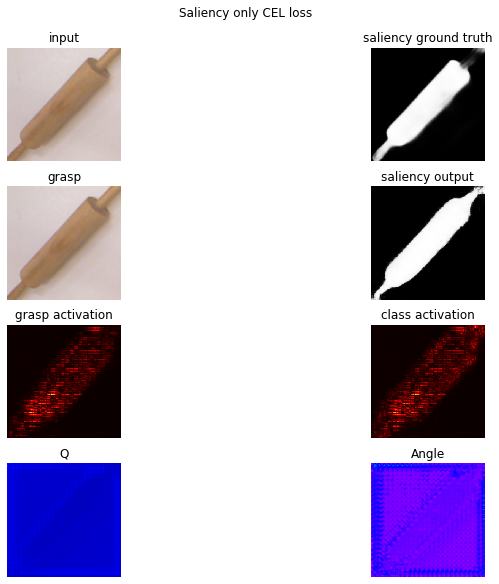

In [13]:
net = torch.load('/media/will/research/mtgrasp/output/models/Saliency_mt/200506_1708_rgbdsaliencycel/epoch_28_iou_0.00_maxf_0.78')
net.to(device)
net.eval()

output(i, net, title='Saliency only CEL loss')

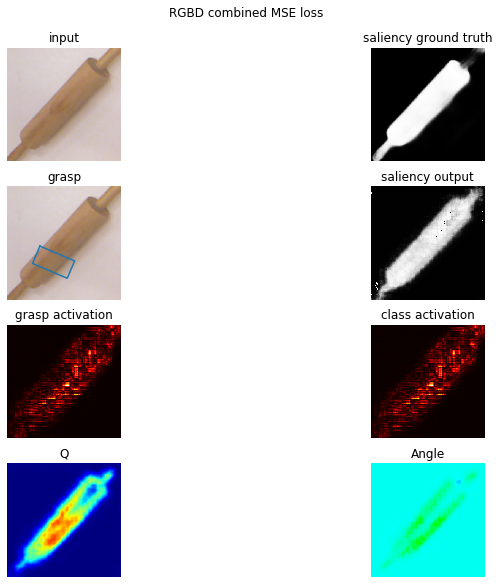

In [14]:
net = torch.load('/media/will/research/mtgrasp/output/models/Saliency_mt/200506_1021_graspsalrgbd/epoch_22_iou_0.86_maxf_0.75')
net.to(device)
net.eval()

output(i, net, title='RGBD combined MSE loss')

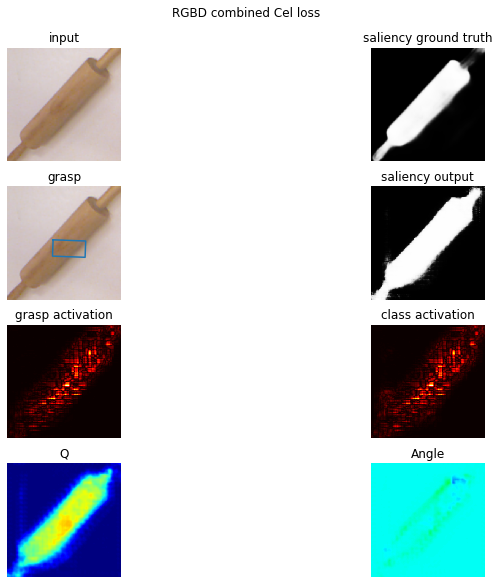

In [15]:
net = torch.load('/media/will/research/mtgrasp/output/models/Saliency_mt/200506_1304_rgbdcelloss/epoch_14_iou_0.84_maxf_0.77')
net.to(device)
net.eval()

output(i, net, title='RGBD combined Cel loss')

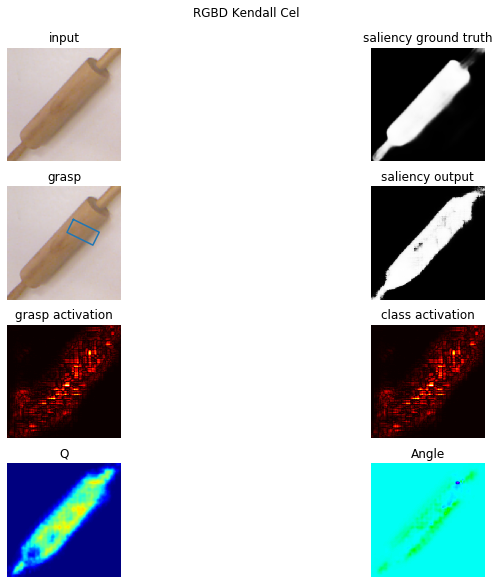

In [16]:
net = torch.load('/media/will/research/mtgrasp/output/models/Saliency_mt/200506_1418_rgbdkendallcelloss/epoch_21_iou_0.85_maxf_0.78')
net.to(device)
net.eval()

output(i, net, title='RGBD Kendall Cel')